# Convert an ESRI shapefile *(.shp)* to a NMSIM trajectory *(.trj)*
<font color="salmon" size=4>**Note:** </font><font size=4>This tool requires use of the NSNSD `geo` Python environment.</font>


----

<font size=4> Before using this tool, <font color="salmon">you must run</font> `NMSIM Create Base Layers` in ArcGIS.</font>
<br><br>

----

### Expected Input

The main input to this script is an ESRI shapefile of aircraft GPS positions (real or abstracted.) As such the input is expected in WGS84, and it must have the following $p \ (x, y, z)$ columns:

>**latitude** (in D.d, WGS84)<br><br>
>**longitude** (in D.d, WGS84)<br><br>
>**surface_elev_m** (surface elevation in meters above Mean Sea Level) <br> 

Using a surface elevation input allows aircraft altitudes Above Ground Level (AGL) to be computed quickly as needed. Aircraft altitude is defined relative to the surface as the variable `AGL`, below.

### Output

This notebook will create a trajectory and save it to the project folder you designated when using `NMSIM Create Base Layers` (i.e., to _"..\Input_Data\03_TRAJECTORY\somename.trj"_).

----

<br><br>

## [Step 1] Import and Define

In [84]:
# ============= import modules (and IPython 'Magic') ====================

# geospatial libraries
import pyproj
import geopandas as gpd

# a convenient file-selector dialog
%gui qt
from PyQt5.QtWidgets import QFileDialog

# other libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import glob
import os

# ================= define functions ====================

def gui_fname(dir=None, guidance="Select data file..."):
    
    """Select a file via a dialog and return the file name."""
    
    if dir is None: dir ='./'
    fname = QFileDialog.getOpenFileName(None, guidance, 
                dir, filter="Shape Files (*.shp)")
    return fname[0]

def climb_angle(v):
    
    """
    compute the 'climb angle' of a vector
    A = 𝑛•𝑏=|𝑛||𝑏|𝑠𝑖𝑛(𝜃)
    """
    
    # a unit normal vector perpendicular to the xy plane
    n = np.array([0,0,1])
    
    degrees = np.degrees(np.arcsin( np.dot(n, v)/(np.linalg.norm(n)*np.linalg.norm(v))))
    return degrees

def get_utm_zone(project_dir):
    
    """
    Glean the UTM zone that was saved as a suffix to the elevation file's name.
    
    This assumes that the elevation file was clipped using the NSNSD ArcToolbox 
    packaged with this tool.
    """
    
    # the ArcPro tool will figure out the UTM zone associated with the western extent of the file
    # (this is the native UTM zone of the NMSIM project)
    elev_filename = os.path.basename(glob.glob(project_dir + os.sep + r"Input_Data\01_ELEVATION\*.flt")[0])

    # this will glean the UTM zone from the filename as an integer
    UTM_zone = int(elev_filename.split("_")[-1][3:-4])
    
    return UTM_zone


## [Step 2] Set global variables

><font color="green">**line 3**</font> `project_dir`: (str) path to the NMSIM project folder you created with `NMSIM Create Base Layers` <br><br>
><font color="green">**line 7**</font> `velocity`: (float) velocity of the aircraft to be modeled - assumed constant <br><br>
<font color="green">**line 10**</font> `AGL`: (str) altitude of the route in feet AGL<br>

#### <font color=salmon size=4>You must edit this cell.</font>

In [162]:
# ================ Global Variables ======================

# path to the NMSIM project folder you created with NMSIM Create Base Layers
project_dir = r"C:\Users\DBetchkal\Desktop\NMSIM_2014_local\Data\BAND002"

# aircraft velocity ...THIS CELL WILL UNDOUBTEDLY BE CHANGED... 
velocity = 74.7222 # m/s  (for a C-185)

# what is the altitude of the flight in feet Above Ground Level?
AGL = 800 # ft

## [Step 3] Read ESRI shapefile into a `GeoDataFrame`
<font size=3>To reverse track direction, uncomment <font color="green">**line 11**</font>, `track = track.iloc[::-1]`.</font>

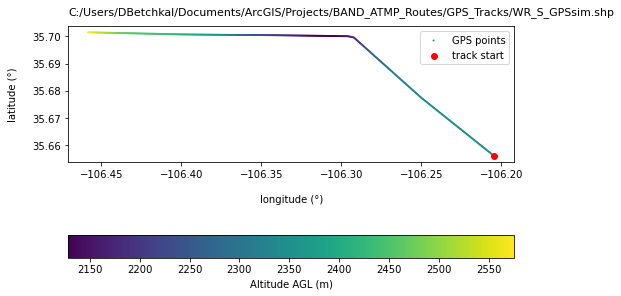

,longitude,latitude,surface_el,geometry,elev_AGL
0,-106.204559,35.656089,2112,POINT (-106.20456 35.65609),2355.839992
1,-106.205060,35.656324,2112,POINT (-106.20506 35.65632),2355.839992
2,-106.205561,35.656560,2112,POINT (-106.20556 35.65656),2355.839992
3,-106.206062,35.656795,2112,POINT (-106.20606 35.65680),2355.839992
4,-106.206563,35.657031,2112,POINT (-106.20656 35.65703),2355.839992
...,...,...,...,...,...
473,-106.456111,35.701506,2321,POINT (-106.45611 35.70151),2564.839992
474,-106.456665,35.701513,2325,POINT (-106.45666 35.70151),2568.839992
475,-106.457218,35.701520,2327,POINT (-106.45722 35.70152),2570.839992
476,-106.457772,35.701528,2331,POINT (-106.45777 35.70153),2574.839992


In [163]:
# use the file selector to find the ESRI shapefile you'd like to process (.shp)
track_path = gui_fname(guidance="Select ESRI shapefile (.shp) of track...")

# load the track, plot it for confirmation, and print the attribute table
fig, ax = plt.subplots(1, 1, figsize=(8, 9))
track = gpd.read_file(track_path)

# add a series with the altitude AGL (but keep it in meters for computation's sake)
track["elev_AGL"] = track["surface_el"] + (AGL/3.28084) 

# track = track.iloc[::-1] # to reverse track direction, uncomment

# plot the points colored by elevation (scaled relative to the current track)
track.plot(column="elev_AGL", markersize=1, 
           ax=ax, label="GPS points", cmap="viridis", 
           legend=True,
           legend_kwds={'label': "Altitude AGL (m)",
                         'orientation': "horizontal"})

# plot the start of the track as a large red point
track.head(1).plot(markersize=35, color="red", ax=ax,
                   zorder=5, label="track start")

# the default aspect tends to stretch everything horizontally... adjust
ax.set_aspect(1.7)

# label the plot
plt.title(track_path, loc="left", fontsize=11, y=1.04)
plt.xlabel("longitude (°)", labelpad=15)
plt.ylabel("latitude (°)", labelpad=15)
plt.legend()
plt.show()

track

## [Step 4] Add all NMSIM prerequisite calculations to the GeoDataFrame
This allows a preview of results before saving.

In [164]:
# find the UTM zone from the elevation (.flt) file generated by `NMSIM Create Base Layers`
zone = get_utm_zone(project_dir)

# epsg codes for UTM zones in the United States (haven't tested Hawaii yet!)
epsg_lookup = {1:'epsg:26901', 2:'epsg:26902', 3:'epsg:26903', 4:'epsg:26904', 5:'epsg:26905', 
               6:'epsg:26906', 7:'epsg:26907', 8:'epsg:26908', 9:'epsg:26909', 10:'epsg:26910', 
               11:'epsg:26911', 12:'epsg:26912', 13:'epsg:26913', 14:'epsg:26914', 15:'epsg:26915',
               16:'epsg:26916', 17:'epsg:26917'}

# convert from D.d (WGS84) to meters (NAD83)
projector = pyproj.Transformer.from_crs('epsg:4326', epsg_lookup[zone])

# convert into the NMSIM project's coordinate system
long, lat = projector.transform(track["latitude"].values, track["longitude"].values)

# write to the geopandas dataframe
track["long_UTM"] = long
track["lat_UTM"] = lat

# convert the p(x, y, z) data into an array of vectors
V = np.diff(np.array([[x, y, z] for x, y, z in zip(track['long_UTM'], 
                                                   track['lat_UTM'], 
                                                   track['elev_AGL'])]), axis=0) 

# headings using the x and y components of each vector; add np.nan to the end
headings = np.degrees(np.arctan2(V.T[0], V.T[1]))
headings = np.append(headings, np.nan)

# a unit normal vector perpendicular to the xy plane
n = np.array([0,0,1])

# climb angle using the vector and the unit normal in the xy plane; add np.nan to the end
climb_angles = np.array([climb_angle(v) for v in V])
climb_angles = np.append(climb_angles, np.nan)

# compute the time elapsed given cruising velocity of the aircraft in question; add np.nan to the end
time_elapsed = np.cumsum(velocity/np.array([np.linalg.norm(v) for v in V]))
time_elapsed = np.append(time_elapsed, np.nan)

# convert airspeed to knots and write it to the geodataframe
track["knots"] = np.full(track["longitude"].shape, 1.94384*velocity, dtype=None, order='C')

# write the remaining data to the geodataframe
track["climb_angle"] = climb_angles
track["time_elapsed"] = time_elapsed
track["heading"] = headings

track

,longitude,latitude,surface_el,geometry,elev_AGL,long_UTM,lat_UTM,knots,climb_angle,time_elapsed,heading
0,-106.204559,35.656089,2112,POINT (-106.20456 35.65609),2355.839992,390963.918366,3.946473e+06,145.248001,0.000000,1.427657,-59.354646
1,-106.205060,35.656324,2112,POINT (-106.20506 35.65632),2355.839992,390918.889070,3.946500e+06,145.248001,0.000000,2.855318,-59.354276
2,-106.205561,35.656560,2112,POINT (-106.20556 35.65656),2355.839992,390873.860040,3.946526e+06,145.248001,0.000000,4.282981,-59.354061
3,-106.206062,35.656795,2112,POINT (-106.20606 35.65680),2355.839992,390828.831184,3.946553e+06,145.248001,0.000000,5.710647,-59.353537
4,-106.206563,35.657031,2112,POINT (-106.20656 35.65703),2355.839992,390783.802684,3.946580e+06,145.248001,0.000000,7.138316,-59.353167
...,...,...,...,...,...,...,...,...,...,...,...
473,-106.456111,35.701506,2321,POINT (-106.45611 35.70151),2564.839992,368266.810590,3.951819e+06,145.248001,4.565558,694.249867,-88.226466
474,-106.456665,35.701513,2325,POINT (-106.45666 35.70151),2568.839992,368216.742605,3.951820e+06,145.248001,2.286408,695.740379,-88.226143
475,-106.457218,35.701520,2327,POINT (-106.45722 35.70152),2570.839992,368166.674624,3.951822e+06,145.248001,4.565557,697.227345,-88.225946
476,-106.457772,35.701528,2331,POINT (-106.45777 35.70153),2574.839992,368116.606647,3.951824e+06,145.248001,1.362448,699.004013,-88.225510


## [Step 5] Input an meaningful identifer for this modelling scenario
For the **file name suffix** *and* a row in **the metadata header.** <br><br>
For example:

>"N74PS beginning 20190610 173326 UTC" <br><br>
>"C-185 ER_N 800ftAGL" <br>

In [165]:
print(os.path.basename(track_path), str(AGL)+"ftAGL")

id_string = input()

WR_S_GPSsim.shp 800ftAGL
C-185 WR_S 800ftAGL


## [Step 6] Save the trajectory file

In [166]:
# path to the specific .trj file to be written
trj_path = project_dir + os.sep + r"Input_Data\03_TRAJECTORY" + os.sep + id_string + ".trj"

print("writing", trj_path)

with open(trj_path, 'w') as trajectory:

    # write the header information [exactly as NMSIM expects!]
    trajectory.write("Flight track trajectory variable description:\n")
    trajectory.write(" time - time in seconds from the reference time\n")
    trajectory.write(" Xpos - x coordinate (UTM)\n")
    trajectory.write(" Ypos - y coordinate (UTM)\n")
    trajectory.write(" UTM Zone  "+str(zone)+"\n")
    trajectory.write(" Zpos - z coordinate in meters MSL\n")
    trajectory.write(" heading - aircraft compass bearing in degrees\n")
    trajectory.write(" climbANG - aircraft climb angle in degrees\n")
    trajectory.write(" vel - aircraft velocity in knots\n")
    trajectory.write(" power - % engine power\n")
    trajectory.write(" roll - bank angle (right wing down), degrees\n")
    trajectory.write("FLIGHT " + id_string + "\n")
    trajectory.write("TEMP.  59.0\n")
    trajectory.write("Humid.  70.0\n")
    trajectory.write("\n")
    trajectory.write("         time(s)        Xpos           Ypos           Zpos         heading        climbANG       Vel            power          rol\n")

    # now write the data section row by row 
    # (except for the last row - it's null due to the differencing)
    for ind, point in track.iloc[:-1].iterrows():

        # write the line
        trajectory.write("{0:15.3f}".format(point["time_elapsed"]) + \
                         "{0:15.3f}".format(point["long_UTM"]) + \
                         "{0:15.3f}".format(point["lat_UTM"]) + \
                         "{0:15.3f}".format(0.3048*point["elev_AGL"]) + \
                         "{0:15.3f}".format(point["heading"]) + \
                         "{0:15.3f}".format(point["climb_angle"]) + \
                         "{0:15.3f}".format(point["knots"]) + \
                         "{0:15.3f}".format(95) + \
                         "{0:15.3f}".format(0) + "\n")

    print("\t\t\t...finished writing .trj", "\n")


writing C:\Users\DBetchkal\Desktop\NMSIM_2014_local\Data\BAND002\Input_Data\03_TRAJECTORY\C-185 WR_S 800ftAGL.trj
			...finished writing .trj 

